In [35]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt

%matplotlib inline

In [211]:
vacs = tifffile.imread("vacuoles.tif")
vacs.shape

(51, 2, 512, 496)

In [212]:
brightfield = vacs[:,1,:,:]
gfp = vacs[:,0,:,:]

In [213]:
mid_slice = 26
b_middle = brightfield[mid_slice,:,:]
g_middle = gfp[mid_slice,:,:]

[[86 87 88 ... 80 87 84]
 [89 93 94 ... 85 89 91]
 [92 82 95 ... 87 87 83]
 ...
 [89 90 80 ... 87 94 98]
 [89 92 86 ... 84 91 86]
 [90 88 88 ... 84 85 82]]


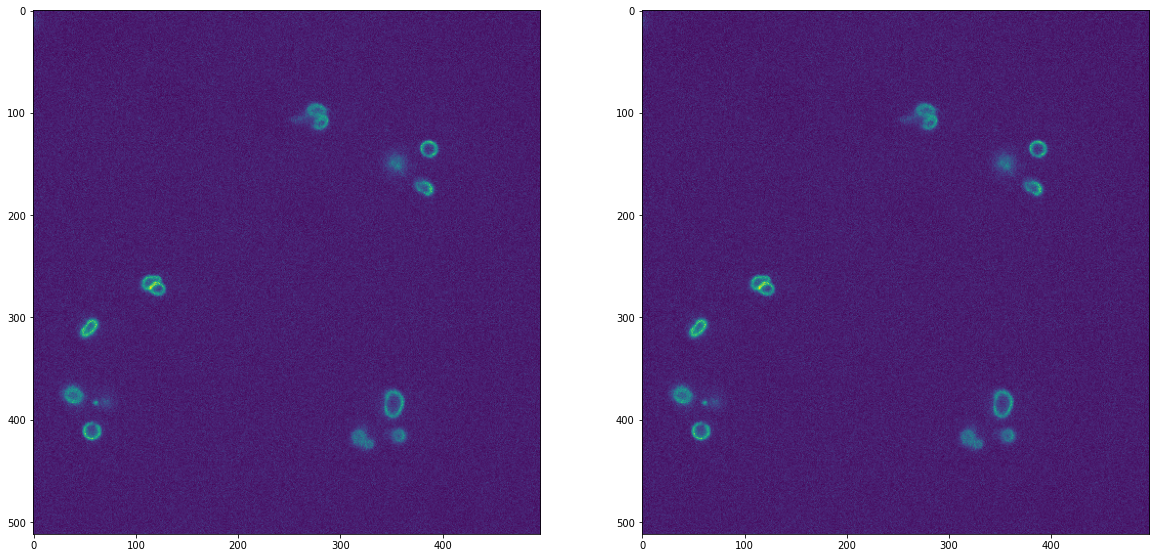

In [251]:
#g8 = g_middle.astype(np.uint8)
gmax = g_middle.max()

# Normalize the values
g_norm = g_middle/gmax
g8 = (g_norm*255).astype(np.uint8)
print(g8)


fig,ax = plt.subplots(1,2,figsize=(20,20))
ax[0].imshow(g_middle)
ax[1].imshow(g8)

In [196]:
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

from skimage import exposure
from skimage.filters import threshold_otsu

# Issues
1. imshow cannot display 16bit RGB values so converting gray2rgb is a problem
2. equalizing histogram on original image closes vacuoles into solid circlles
3. might need to consider binarizing first

88.74024225050404


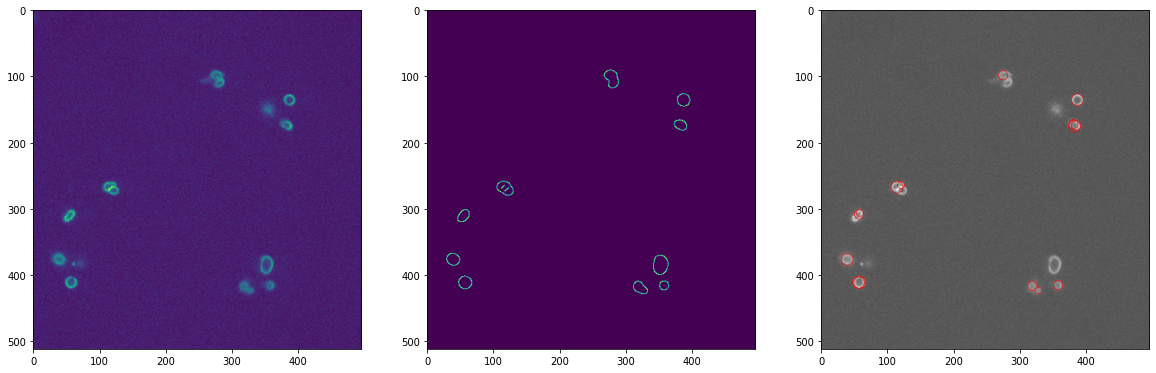

In [280]:
# TODO: find a method to predict number of vacuoles
def annotate_slice(img_slice, num_vacs):   
    # NOTE: these break canny for some reason
    # Equalization
    img_eq = exposure.equalize_hist(img_slice)
    # Adaptive Equalization
    img_adapteq = exposure.equalize_adapthist(img_slice,kernel_size=32,clip_limit=0.5)
    
    # Binarization
    thresh = threshold_otsu(img_slice)
    binary = img_slice > thresh
    
    # Edge detection
    edges = canny(img_slice, sigma=3, low_threshold=0, high_threshold=40)
    hough_radii = np.arange(5, 20, 2) # Radius guesses? TODO: read more on this
    
    # Circle fitting
    hough_res = hough_circle(edges, hough_radii)
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                               total_num_peaks=num_vacs)
    
    #####---#####
    
    #color_img = color.gray2rgb(img_slice)
    #print(color_img)
    #color_img8 = color_img.astype(np.uint8)
    #print(color_img)

    
    color_img = color.gray2rgb(img_slice)
    #print(len(img_slice), len(color_img))
    #print(color_img.shape)
    #print(img_slice.dtype,color_img.dtype)
    
    
    for center_y, center_x, radius in zip(cy, cx, radii):
        circy, circx = circle_perimeter(center_y, center_x, radius,
                                        shape=img_slice.shape)
        color_img[circy, circx] = (255, 0, 0)

    
    fig1,steps = plt.subplots(1,3,figsize=(20,20))
    steps[0].imshow(img_slice)
    steps[1].imshow(edges)
    steps[2].imshow(color_img)
    


test = np.array(g_middle)
test_norm = test/test.max()
test_scaled = (test_norm*255).astype(np.uint8)
print(test_scaled.mean())
annotate_slice(test_scaled, 15)